# 3DVar

In [1]:
import autoroot
from pathlib import Path
import numpyro
import numpyro.distributions as dist
from jax import config
config.update("jax_enable_x64", True)
import einx
import jax
import jax.numpy as jnp
import numpy as np
import jax.random as jr
import xarray as xr
from jaxtyping import Float, Array
import cola
from oi_toolz._src.ops.kernels import kernel_rbf, gram
from oi_toolz._src.ops.linalg import create_psd_matrix
from oi_toolz._src.ops.varda import (
    linear_3dvar_model_space,
    linear_3dvar_model_space_incremental,
    linear_3dvar_obs_space_incremental
)
from cola.linalg import Auto
from oi_toolz._src.ops.enskf import analysis_etkf
from sklearn.datasets import make_spd_matrix, make_sparse_spd_matrix

key = jr.key(123)

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

## Example

In [41]:
import equinox as eqx
import diffrax as dfx

In [42]:
data = xr.open_dataset("/Users/eman/code_projects/data/pyda/lorenz63/l63_sim.nc")

In [43]:
data = data.isel(time=slice(None, None, 10))
data

<xarray.Dataset>
Dimensions:             (time: 101, component: 3)
Coordinates:
  * time                (time) float32 0.0 0.1 0.2 0.3 0.4 ... 9.7 9.8 9.9 10.0
  * component           (component) <U1 'x' 'y' 'z'
Data variables:
    simulation          (component, time) float32 ...
    observations        (component, time) float32 ...
    observations_noisy  (component, time) float64 ...

### Dynamical System

In [44]:
from oi_toolz._src.models.l63 import L63Params, L63State, l63_equation_of_motion

#### Observation Operator

In [45]:
def obs_op(u):
    return u

def obs_op_der(u):
    return jnp.eye(u.shape[0])

#### Parameters

In [46]:
num_dim_x = num_dim_y = 3

params = L63Params(
    sigma=data.simulation.attrs["sigma"].astype(np.float64),
    rho=data.simulation.attrs["rho"].astype(np.float64),
    beta=data.simulation.attrs["beta"].astype(np.float64),
)

sigma_y = 0.15
R = sigma_y**2 * cola.ops.Diagonal(jnp.ones(num_dim_y))
H = jnp.eye(num_dim_y)

In [47]:
ts = data.time.values
dt = ts[1] - ts[0]

In [48]:
from tqdm.auto import tqdm

In [49]:
data["ts_diff"] = data.time.diff("time")

dt = data["ts_diff"].values[1]

In [50]:
dt

0.1

### Missing Data

In [51]:
dt_obs = 0.2
t_max_obs = 5
t_steps_obs = int(t_max_obs/dt_obs)

In [52]:
ind_obs = np.linspace(int(dt_obs/dt), int(t_max_obs/dt), t_steps_obs).astype(int)

In [53]:
data["observations"] =  xr.full_like(data["simulation"], np.nan)
data["observations"][:, ind_obs] = data["simulation"][:, ind_obs]

#### Noise

In [54]:
rng = np.random.RandomState(123)
sigma_y = 0.15

noise =  sigma_y**2 * rng.randn(*data["observations"].shape)

data["observations_noisy"] = data["observations"] + noise

In [55]:
noise

array([[-2.44266886e-02,  2.24402725e-02,  6.36701621e-03,
        -3.38916311e-02, -1.30185057e-02,  3.71573221e-02,
        -5.46002830e-02, -9.65053415e-03,  2.84835658e-02,
        -1.95016591e-02, -1.52749384e-02, -2.13095180e-03,
         3.35562666e-02, -1.43752949e-02, -9.98959409e-03,
        -9.77290370e-03,  4.96334269e-02,  4.92026870e-02,
         2.25912127e-02,  8.68919398e-03,  1.65907930e-02,
         3.35414706e-02, -2.10562620e-02,  2.64561535e-02,
        -2.82123150e-02, -1.43494088e-02,  2.04098669e-02,
        -3.21453158e-02, -3.15154620e-03, -1.93894852e-02,
        -5.75143584e-03, -6.29682549e-02, -3.98594949e-02,
        -1.57472378e-02,  2.08679047e-02, -3.90680286e-03,
         6.40331077e-05,  1.54850110e-02, -1.97895677e-02,
         6.38161479e-03, -1.81207467e-02, -3.88725636e-02,
        -8.79524536e-03,  1.29106319e-02,  7.61825365e-03,
        -2.66186126e-04,  5.38282185e-02,  9.29052361e-03,
         2.20215601e-02,  5.03582251e-02, -2.91169198e-0

In [76]:
d = jnp.ones(shape=(100,100,10))

In [78]:
einx.mean("B [...]", d).shape

(100,)

In [65]:
# initial parameters
mu_u = jnp.asarray([2.0, 3.0, 4.0])
sigma_u = 0.1
Sigma_u = cola.ops.Diagonal(sigma_u ** 2 *jnp.ones(3))
sigma_y = cola.ops.Diagonal(0.15*jnp.ones(3))

```python
def rhs(t, y, args):
    x, P = y

    # eq 3.22 of Ref [1]
    K = P @ C.transpose() @ jnp.linalg.inv(self.R)

    # eq 3.21 of Ref [1]
    dPdt = (
        A @ P
        + P @ A.transpose()
        + self.Q
        - P @ C.transpose() @ jnp.linalg.inv(self.R) @ C @ P
    )

    # eq 3.23 of Ref [1]
    dxdt = A @ x + B @ u_t.evaluate(t) + K @ (y_t.evaluate(t) - C @ x)

    return (dxdt, dPdt)
```

In [75]:
isinstance(sigma_y, cola.ops.Diagonal)

True

In [66]:
class KFState(eqx.Module):
    mu: Float[Array, "Du"]
    Sigma_u: Float[Array, "D D"]
    
class KFParams(eqx.Module):
    F: Float[Array, "Du Du"]
    H: Float[Array, "Dy Du"]
    Sigma_y: cola.ops.operators.LinearOperator
    

def kf_rhs(t, state, params):
    
    # calculate rhs
    ua
    
    

$$
\begin{aligned}
\partial_t\mathbf{u}_\mu = \boldsymbol{\mu}_u  + 
\boldsymbol{\Sigma}_\mathbf{u}
\mathbf{H}^\top\boldsymbol{\Sigma}_\mathbf{y}^{-1} 
(\mathbf{y} - \mathbf{Hu}) \\
\partial_t \mathbb{}
\end{aligned}
$$

In [ ]:
class KFParams(eqx.Module):
    

In [ ]:
class DynamicModel(eqx.module):
    
    def __call__(self, 

In [57]:
data["predictions_mu"] = np.nan * data["simulation"]
data["predictions_q25"] = np.nan * data["simulation"]
data["predictions_q95"] = np.nan * data["simulation"]

In [58]:
solver = dfx.Tsit5() #  dfx.Dopri5() # dfx.Euler() #  
stepsize_controller = dfx.PIDController(rtol=1e-7, atol=1e-7) # dfx.ConstantStepSize() #

In [59]:
# def kf_update(y, Sigma_y, H, mu_u, Sigma_u, inv_alg=Auto()):
    
#     # compute Kalman Gain
#     D = cola.ops.Dense(H @ Sigma_u @ H.T - Sigma_y)
#     K = Sigma_u @ H @ cola.inv(D, alg=inv_alg)
#     K = cola.ops.Dense(K)
    
#     # compute analysis
#     ua = ub + K @ (y - H @ mu_u)
#     P = cola.ops.I_like(Sigma_u) - K @ H @ Sigma_u
    
#     return ua, P

In [60]:
num_ensembles = 10

In [61]:
# ua, _ = kf_update(y, sigma_y, H, mu_u, sigma_x)

In [62]:
L63State.from_array(mu_u)

L63State(x=f64[], y=f64[], z=f64[])

In [63]:
for iteration, (itime, ids) in tqdm(enumerate(list(data.groupby("time")))):
    

    if iteration == 0:
        # use this as background state for next iteration
        mu_u = ids.simulation.values
        mu_u_ens = rng.multivariate_normal(mean=mu_u, cov=Sigma_u.to_dense(), size=(num_ensembles,))
        # continue the loop
        continue
    
    
    # use previous background state to make prediction
    u_ens = L63State.from_array(mu_u_ens)
    
    
    itime = itime.astype(np.float64)
    # do forward prediction
    def fn(u_ens):
        return dfx.diffeqsolve(
        terms=dfx.ODETerm(l63_equation_of_motion),
        t0=itime,
        t1=itime + dt,
        dt0=dt,
        y0=u_ens,
        args=params,
        solver=solver,
        stepsize_controller=stepsize_controller,
    )
    sol = jax.vmap(fn)(u_ens)
    
    # extract array from state
    mu_u_ens = sol.ys.to_array().squeeze()
    
    # compute forecast Error covariance
    
    
    
    # if we dont have observations (do analysis)
    y = ids.observations_noisy.values
    
    if np.sum(np.isnan(y)):
        # if there are no observations no analysis
        mu_a_ens = mu_u_ens.copy()
    else:
        # if there no observations - do analysis
        Xf = mu_u_ens.T
        HXf = jnp.einsum("ND,HD->HN", mu_u_ens, H)
        Xa = analysis_etkf(
            Xf=Xf, HXf=HXf, 
            Y=y, R=sigma_y
        )
        mu_a_ens = Xa.T
        
    # if we do have observations (don't do analysis)
    data["predictions_mu"][:, iteration] = np.mean(mu_a_ens, axis=0)
    data["predictions_q25"][:, iteration] = np.quantile(mu_a_ens, q=0.25, axis=0)
    data["predictions_q95"][:, iteration] = np.quantile(mu_a_ens, q=0.95, axis=0)
    mu_u_ens = mu_a_ens.copy()

0it [00:00, ?it/s]

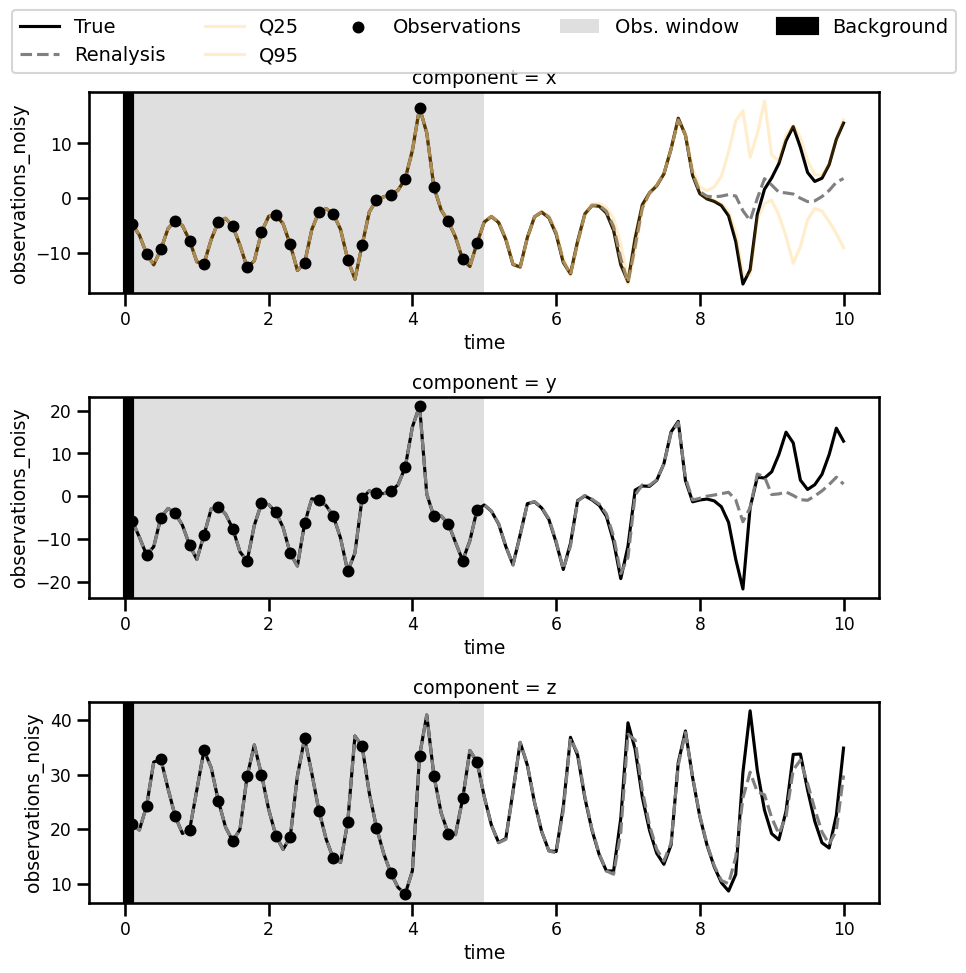

In [64]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

# Plot Simulation Data
data.simulation.sel(component="x").plot(ax=ax[0], color="black", label="True")
data.simulation.sel(component="y").plot(ax=ax[1], color="black", label="True")
data.simulation.sel(component="z").plot(ax=ax[2], color="black", label="True")

# plot Reanalysis Data
data.predictions_mu.sel(component="x").plot(ax=ax[0], color="gray", linestyle="--", label="Renalysis")
data.predictions_q25.sel(component="x").plot(ax=ax[0], color="orange", alpha=0.2, linestyle="-", label="Q25")
data.predictions_q95.sel(component="x").plot(ax=ax[0], color="orange", alpha=0.2, linestyle="-", label="Q95")

data.predictions_mu.sel(component="y").plot(ax=ax[1], color="gray", linestyle="--", label="Renalysis")
data.predictions_mu.sel(component="z").plot(ax=ax[2], color="gray", linestyle="--", label="Renalysis")


data.observations_noisy.sel(component="x").plot.scatter(ax=ax[0], zorder=3, color="black", marker=".", s=200, label="Observations")
data.observations_noisy.sel(component="y").plot.scatter(ax=ax[1], zorder=3, color="black", marker=".", s=200, label="Observartions")
data.observations_noisy.sel(component="z").plot.scatter(ax=ax[2], zorder=3, color="black", marker=".", s=200, label="Observartions")

# Draw Observation Window
ax[0].axvspan(0 + dt, t_max_obs, color="gray", alpha=0.25, lw=0, label="Obs. window")
ax[1].axvspan(0 + dt, t_max_obs, color="gray", alpha=0.25, lw=0, label="Obs. window")
ax[2].axvspan(0 + dt, t_max_obs, color="gray", alpha=0.25, lw=0, label="Obs. window")

# Draw Background Window
ax[0].axvspan(0, dt, color="black", lw=3, zorder=5, label="Background")
ax[1].axvspan(0, dt, color="black", lw=3, zorder=5, label="Background")
ax[2].axvspan(0, dt, color="black", lw=3, zorder=5, label="Background")

# create Legend
ax[0].legend(loc="center", bbox_to_anchor=(0.5, 1.25), fontsize=14, ncols=5,)

plt.tight_layout()
plt.show()